In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

<br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 304)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [20]:
class MLP() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
    
    def day_MLP(self, X_input) :
        layer = tf.layers.dense(X_input, self.emb_dim)
        
        for idx in range(self.num_layer//3+1) :
            norm1 = tf.contrib.layers.layer_norm(layer)
            relu1 = tf.nn.leaky_relu(norm1)
            layer1 = tf.layers.dense(relu1, self.emb_dim*2)
                
            norm2 = tf.contrib.layers.layer_norm(layer1)
            relu2 = tf.nn.leaky_relu(norm2)
            layer2 = tf.layers.dense(relu2, self.emb_dim)
            
            layer = layer2 + layer
                
        summary_layer = tf.layers.dense(layer, self.emb_dim//2)
        return summary_layer
    
    def build(self, batch_size, input_dim, emb_dim, output_dim, num_layer, num_unit, activation) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            # input  : ? x input_length x input_dim
            self.X = tf.placeholder(tf.float32, [None, input_dim])
            self.Y = tf.placeholder(tf.float32, [None, output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            
            self.batch_size = batch_size
            self.day_dim = input_dim//8
            self.emb_dim = emb_dim
            self.output_dim = output_dim
            self.num_layer = num_layer
            self.num_unit = num_unit
            self.activation = activation
            #############
            
            
            ## MLP ##
            day1 = self.day_MLP(self.X[:,:self.day_dim])
            day2 = self.day_MLP(self.X[:,self.day_dim : self.day_dim*2])
            day3 = self.day_MLP(self.X[:,self.day_dim*2 : self.day_dim*3])
            day4 = self.day_MLP(self.X[:,self.day_dim*3 : self.day_dim*4])
            day5 = self.day_MLP(self.X[:,self.day_dim*4 : self.day_dim*5])
            day6 = self.day_MLP(self.X[:,self.day_dim*5 : self.day_dim*6])
            day7 = self.day_MLP(self.X[:,self.day_dim*6 : self.day_dim*7])
            day8 = self.day_MLP(self.X[:,self.day_dim*7 :])
            
            day_total = tf.concat([day1,day2,day3,day4,day5,day6,day7,day8], axis=1)
            day_norm = tf.contrib.layers.layer_norm(day_total)
            day_relu = tf.nn.leaky_relu(day_norm)
            layer = tf.layers.dense(day_relu, self.num_unit)
            
            for idx in range((self.num_layer-2)//2) :
                norm1 = tf.contrib.layers.layer_norm(layer)
                relu1 = tf.nn.relu(norm1)
                layer1 = tf.layers.dense(relu1, self.num_unit)
                
                norm2 = tf.contrib.layers.layer_norm(layer1)
                relu2 = tf.nn.relu(norm2)
                layer2 = tf.layers.dense(relu2, self.num_unit)
                
                layer = tf.layers.dropout(layer2 + layer, training=self.training)
                
            layer = tf.layers.dense(layer, self.output_dim)
            #########################
            
            
            ## Classifier ##
            self.logit = layer
            self.softmax = tf.nn.softmax(self.logit)
            self.softmax_logit = tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y)
            ################
            
            
            ## Learning ##
            self.cost = tf.reduce_sum(self.softmax_logit)
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [27]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [30]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 100
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [29]:
idx = 0
model_lst = []

for num_layer in [6,8,10] :
    for num_unit in [256] :
        for activation in [None,tf.nn.relu] :
            for emb_dim in [38,64] :
                print(idx)
                sess = tf.Session()
                model = MLP(sess, "model{}".format(idx))
                model.build(batch_size, input_dim, emb_dim, 4, num_layer, num_unit, activation)
                sess.run(tf.global_variables_initializer())
            
                model_lst.append(model)
                idx+=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [31]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 70 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 464.61995(58.8%), valid460.75855(59.1%)
-- train 483.30549(58.7%), valid478.67071(59.0%)
-- train 469.50204(59.6%), valid464.33325(60.2%)
-- train 471.22851(57.9%), valid467.53485(58.2%)
-- train 488.52652(54.7%), valid484.93458(54.8%)
-- train 504.68484(56.0%), valid503.30944(56.4%)
-- train 463.78502(60.0%), valid458.11571(60.3%)
-- train 485.59648(57.7%), valid481.88463(57.9%)
-- train 511.08714(58.9%), valid507.37115(59.1%)
-- train 497.81382(54.0%), valid495.49824(54.1%)
-- train 574.43740(53.9%), valid567.11292(54.6%)
-- train 461.88577(59.8%), valid456.76648(60.4%)
Accuracy: 0.5910500019788743
Accuracy: 0.5902999982237815
Accuracy: 0.602250000834465
Accuracy: 0.5820000007748604
Accuracy: 0.5481000050902367
Accuracy: 0.5640000060200692
Accuracy: 0.602650000154972
Accuracy: 0.57945000082254

-- train 378.68314(67.0%), valid381.41401(67.0%)
-- train 392.98641(66.5%), valid396.42442(66.6%)
-- train 396.25567(66.8%), valid398.65430(66.9%)
-- train 409.94994(66.3%), valid411.53859(66.2%)
-- train 401.57086(65.8%), valid404.21133(65.5%)
-- train 394.80575(66.3%), valid397.48290(66.2%)
Accuracy: 0.6721000000834465
Accuracy: 0.6710999980568886
Accuracy: 0.6774499952793122
Accuracy: 0.6606500029563904
Accuracy: 0.6685500040650367
Accuracy: 0.6706000015139579
Accuracy: 0.6695999994874
Accuracy: 0.665949995815754
Accuracy: 0.6685999974608421
Accuracy: 0.6619499966502189
Accuracy: 0.6553000032901763
Accuracy: 0.662200003862381
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  8
-- train 372.27591(67.6%), valid377.45235(67.4%)
-- train 373.29329(67.4%), valid376.92097(67.2%)
-- train 372.77824(67.3%), valid376.03810(67.4%)
-- train 378.97239(66.7%), valid383.15206(66.7%)

Accuracy: 0.6788999944925308
Accuracy: 0.6797500029206276
Accuracy: 0.6744000017642975
Accuracy: 0.6687499925494194
Accuracy: 0.6743000000715256
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  15
-- train 348.90868(69.0%), valid356.65339(68.5%)
-- train 352.55478(68.5%), valid358.91897(68.2%)
-- train 343.55162(69.3%), valid353.55059(68.7%)
-- train 353.00287(68.6%), valid360.56464(68.3%)
-- train 357.14700(68.8%), valid366.29930(68.5%)
-- train 360.28343(68.3%), valid365.74554(68.1%)
-- train 349.46019(69.0%), valid357.68131(68.7%)
-- train 366.87464(67.3%), valid372.68638(67.2%)
-- train 385.63272(67.9%), valid391.29323(67.9%)
-- train 375.23799(67.7%), valid381.61179(67.4%)
-- train 380.03495(67.2%), valid384.44421(67.3%)
-- train 378.08071(67.9%), valid383.64811(67.8%)
Accuracy: 0.6847999960184097
Accuracy: 0.6815499991178513
Accuracy: 0.6869500011205674
Accuracy: 0

-- train 352.10939(68.5%), valid364.42563(67.7%)
-- train 348.09242(68.9%), valid356.41094(68.6%)
-- train 349.73095(68.9%), valid360.12276(68.3%)
-- train 359.58089(68.6%), valid369.10243(68.3%)
-- train 376.42681(67.8%), valid385.13025(67.6%)
-- train 366.25661(68.6%), valid376.34345(68.0%)
-- train 375.69518(68.0%), valid384.29284(67.8%)
-- train 360.15406(68.3%), valid366.59271(68.1%)
Accuracy: 0.6891499981284142
Accuracy: 0.6862499967217446
Accuracy: 0.6876500010490417
Accuracy: 0.688249996304512
Accuracy: 0.6769999995827675
Accuracy: 0.6855000019073486
Accuracy: 0.683349996805191
Accuracy: 0.6829000011086463
Accuracy: 0.6758499965071678
Accuracy: 0.6802999958395958
Accuracy: 0.6782999962568284
Accuracy: 0.6812499955296516
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  23
-- train 342.76885(69.4%), valid356.41460(68.6%)
-- train 348.14586(69.2%), valid358.11831(68

Accuracy: 0.6897999972105027
Accuracy: 0.6885999992489815
Accuracy: 0.6857999995350837
Accuracy: 0.6909499958157539
Accuracy: 0.6860500037670135
Accuracy: 0.6842499986290932
Accuracy: 0.6851999998092652
Accuracy: 0.6814999982714653
Accuracy: 0.6842999964952469
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  30
-- train 336.54908(69.7%), valid352.38247(68.9%)
-- train 337.53241(69.8%), valid349.82349(69.0%)
-- train 333.12577(70.1%), valid349.11336(69.2%)
-- train 342.50726(69.5%), valid356.28635(68.8%)
-- train 344.56514(69.6%), valid356.52712(68.7%)
-- train 358.74035(68.5%), valid368.05352(68.0%)
-- train 345.53091(69.4%), valid358.02387(68.7%)
-- train 353.53548(68.8%), valid364.81951(68.5%)
-- train 365.19376(68.7%), valid371.15144(68.7%)
-- train 358.10755(68.9%), valid368.09681(68.3%)
-- train 372.19609(68.4%), valid381.24190(68.2%)
-- train 362.39905(69.0%), vali

-- train 336.00413(70.0%), valid355.71181(69.0%)
-- train 332.41802(70.1%), valid353.84680(68.8%)
-- train 338.30282(69.8%), valid353.53104(69.3%)
-- train 343.19572(69.7%), valid360.84333(68.9%)
-- train 352.88735(68.7%), valid365.41341(68.4%)
-- train 342.43878(69.4%), valid357.34141(68.7%)
-- train 338.45978(69.6%), valid352.52584(69.0%)
-- train 361.60382(68.4%), valid373.05387(68.0%)
-- train 360.15215(68.6%), valid369.38770(68.3%)
-- train 363.48470(68.3%), valid376.91418(67.8%)
-- train 364.35941(68.4%), valid375.47453(68.1%)
Accuracy: 0.6907499939203262
Accuracy: 0.6895999982953072
Accuracy: 0.6884999975562096
Accuracy: 0.692950002849102
Accuracy: 0.6893500030040741
Accuracy: 0.6842499986290932
Accuracy: 0.6871000036597252
Accuracy: 0.6898999959230423
Accuracy: 0.6803000003099442
Accuracy: 0.6828499972820282
Accuracy: 0.6775000005960464
Accuracy: 0.6807499974966049
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log

-- train 359.62800(69.1%), valid372.49609(68.7%)
Accuracy: 0.6957499906420708
Accuracy: 0.6921999990940094
Accuracy: 0.6920500010251999
Accuracy: 0.6878499954938888
Accuracy: 0.6910999968647957
Accuracy: 0.6855999976396561
Accuracy: 0.693699999153614
Accuracy: 0.6887000024318695
Accuracy: 0.6882999941706658
Accuracy: 0.6887000039219856
Accuracy: 0.6871500015258789
Accuracy: 0.6871999993920326
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  45
-- train 325.30471(70.9%), valid349.52610(69.8%)
-- train 328.47651(70.6%), valid350.42840(69.2%)
-- train 329.06425(70.4%), valid355.75739(69.1%)
-- train 331.75323(70.3%), valid353.47218(69.5%)
-- train 339.34300(69.7%), valid359.24783(69.0%)
-- train 339.51806(69.4%), valid353.95695(68.9%)
-- train 337.38557(69.7%), valid351.86922(69.0%)
-- train 338.89203(69.9%), valid358.71171(69.0%)
-- train 365.74849(68.9%), valid382.06520(6

log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  52
-- train 324.04551(71.1%), valid347.35929(69.6%)
-- train 324.74416(70.8%), valid353.24514(69.2%)
-- train 323.67680(71.0%), valid354.82208(69.4%)
-- train 333.22511(70.4%), valid351.31079(69.5%)
-- train 341.64190(69.3%), valid366.14651(68.1%)
-- train 343.23809(69.5%), valid359.60243(68.9%)
-- train 332.97591(70.4%), valid351.96281(69.6%)
-- train 333.94121(70.1%), valid352.78895(69.2%)
-- train 362.28756(69.0%), valid373.37653(68.6%)
-- train 359.09510(69.5%), valid377.03152(68.8%)
-- train 358.26397(69.1%), valid371.10104(68.6%)
-- train 353.32974(69.1%), valid368.69115(68.7%)
Accuracy: 0.6964999988675118
Accuracy: 0.6917999967932701
Accuracy: 0.6939999997615814
Accuracy: 0.6952499955892563
Accuracy: 0.6809499993920326
Accuracy: 0.6888999968767167
Accuracy: 0.695550000667572
Accuracy: 0.6917499989271164
Accuracy: 0.6855000048875809
Accuracy: 0.6879999980330467
Accuracy: 0.685600000619888

-- train 355.77718(69.3%), valid373.07897(68.7%)
-- train 350.20243(69.6%), valid368.53687(68.9%)
-- train 365.20962(68.8%), valid383.07489(68.1%)
-- train 367.18798(69.0%), valid387.90633(68.5%)
Accuracy: 0.6976500019431114
Accuracy: 0.6936999976634979
Accuracy: 0.6912000000476837
Accuracy: 0.69480000436306
Accuracy: 0.6930000022053718
Accuracy: 0.6929999992251397
Accuracy: 0.6886499986052513
Accuracy: 0.6951000034809113
Accuracy: 0.6870499968528747
Accuracy: 0.6885499939322471
Accuracy: 0.6812000021338462
Accuracy: 0.6849500000476837
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  60
-- train 320.60977(71.6%), valid351.40473(70.1%)
-- train 319.85684(71.5%), valid352.25667(69.9%)
-- train 321.81492(71.1%), valid357.15401(69.4%)
-- train 323.14633(70.9%), valid347.12054(70.0%)
-- train 336.34158(69.8%), valid358.16253(68.7%)
-- train 341.74160(68.7%), valid359.89366(68

Accuracy: 0.6892000034451484
Accuracy: 0.6919499978423118
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  67
-- train 314.91170(71.9%), valid352.41313(69.8%)
-- train 320.75604(71.2%), valid357.18663(69.6%)
-- train 316.72213(71.7%), valid360.24971(69.6%)
-- train 321.66735(71.2%), valid351.27110(69.6%)
-- train 330.99641(70.7%), valid361.65025(69.5%)
-- train 331.30904(70.1%), valid351.00620(69.2%)
-- train 330.22691(70.4%), valid352.60529(69.3%)
-- train 334.95458(70.0%), valid360.00135(69.1%)
-- train 355.58647(69.4%), valid374.57775(68.9%)
-- train 344.50030(69.9%), valid364.62178(69.1%)
-- train 349.76894(69.2%), valid368.74086(68.7%)
-- train 353.77203(69.6%), valid375.40912(69.0%)
Accuracy: 0.6984999984502792
Accuracy: 0.6957000017166137
Accuracy: 0.695949999988079
Accuracy: 0.6957000002264977
Accuracy: 0.6945500001311302
Accuracy: 0.6921499982476235
Accuracy: 0.

-- train 323.54731(70.9%), valid351.12553(69.6%)
-- train 313.17437(72.1%), valid348.93086(70.5%)
-- train 316.96589(71.7%), valid353.90078(70.2%)
-- train 335.70756(70.3%), valid360.87795(69.3%)
-- train 329.54458(70.6%), valid355.97188(69.6%)
-- train 338.96810(70.0%), valid361.54922(69.3%)
-- train 328.95780(70.3%), valid358.03381(69.4%)
Accuracy: 0.7050000011920929
Accuracy: 0.7032499983906746
Accuracy: 0.7004499956965446
Accuracy: 0.7023499980568886
Accuracy: 0.6995499953627586
Accuracy: 0.6963499963283539
Accuracy: 0.7048000007867813
Accuracy: 0.7018000021576881
Accuracy: 0.6928999930620193
Accuracy: 0.6964999973773957
Accuracy: 0.6925500005483627
Accuracy: 0.6938499942421913
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  75
-- train 302.27773(72.9%), valid360.31653(70.3%)
-- train 307.07657(72.3%), valid363.75012(69.9%)
-- train 300.36993(73.0%), valid382.82612(

Accuracy: 0.7015999898314476
Accuracy: 0.7065500006079674
Accuracy: 0.7048499986529351
Accuracy: 0.6987499967217445
Accuracy: 0.6965999975800514
Accuracy: 0.6983999967575073
Accuracy: 0.6971500024199486
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  82
-- train 275.36435(74.9%), valid373.76664(71.0%)
-- train 282.25388(74.2%), valid375.15292(70.5%)
-- train 273.28798(75.0%), valid386.98062(70.4%)
-- train 287.69037(74.0%), valid355.99190(70.7%)
-- train 300.35117(73.1%), valid364.25172(70.4%)
-- train 305.34072(72.4%), valid350.28214(70.4%)
-- train 297.26262(73.4%), valid358.07796(70.7%)
-- train 300.10033(72.7%), valid355.41824(70.6%)
-- train 324.36864(71.4%), valid361.15482(70.1%)
-- train 322.39941(71.5%), valid366.66287(69.8%)
-- train 331.02643(70.8%), valid365.34461(69.7%)
-- train 324.96638(71.3%), valid371.23206(69.7%)
Accuracy: 0.7096999987959862
Accuracy: 0

-- train 266.32648(75.5%), valid410.63062(70.2%)
-- train 281.19781(74.5%), valid373.84083(70.5%)
-- train 297.54281(73.4%), valid376.96315(70.4%)
-- train 299.51264(72.9%), valid357.63047(70.2%)
-- train 290.94843(73.8%), valid367.29176(70.9%)
-- train 297.05763(73.2%), valid364.22269(70.6%)
-- train 318.95383(71.8%), valid364.10353(70.3%)
-- train 320.07151(71.8%), valid374.26567(69.9%)
-- train 332.60503(71.0%), valid373.72283(69.8%)
-- train 320.57837(71.6%), valid376.55482(69.7%)
Accuracy: 0.7085499972105026
Accuracy: 0.7045499980449677
Accuracy: 0.7021999970078469
Accuracy: 0.7048500016331672
Accuracy: 0.7041999965906143
Accuracy: 0.7023499965667724
Accuracy: 0.7092500001192092
Accuracy: 0.7056499972939492
Accuracy: 0.7026999935507774
Accuracy: 0.6987999945878982
Accuracy: 0.697699998319149
Accuracy: 0.6973499998450279
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** 

Accuracy: 0.7089999973773956
Accuracy: 0.704500000178814
Accuracy: 0.6997999951243401
Accuracy: 0.703599999845028
Accuracy: 0.7040499940514564
Accuracy: 0.6992499977350235
Accuracy: 0.7078999966382981
Accuracy: 0.7050499975681305
Accuracy: 0.700849997997284
Accuracy: 0.6991499960422516
Accuracy: 0.6990999937057495
Accuracy: 0.6965499997138977
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  97
-- train 263.96218(75.9%), valid429.20091(70.8%)
-- train 269.63488(75.2%), valid424.92986(70.3%)
-- train 260.69774(76.0%), valid441.43003(70.1%)
-- train 275.74106(75.0%), valid393.38421(70.3%)
-- train 291.26500(73.9%), valid387.49029(70.4%)
-- train 296.14340(73.2%), valid367.08930(70.1%)
-- train 285.73873(74.2%), valid379.56848(70.7%)
-- train 293.21257(73.6%), valid370.58761(70.7%)
-- train 318.99164(72.0%), valid371.45518(70.1%)
-- train 318.07645(72.0%), valid383.95509(69.

 <br></br><br></br><br></br> 

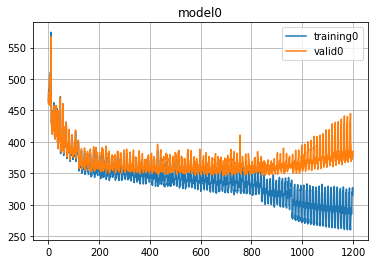

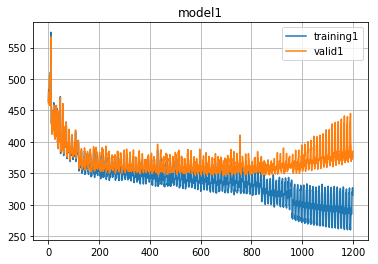

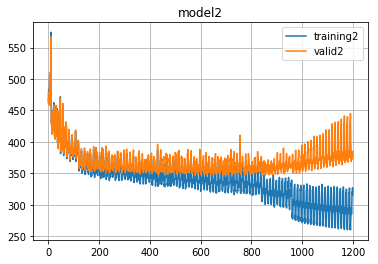

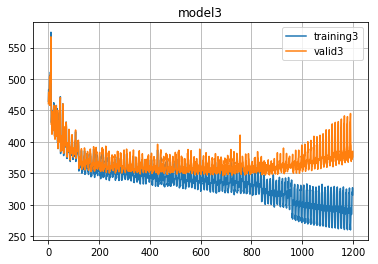

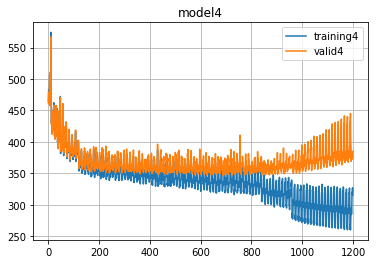

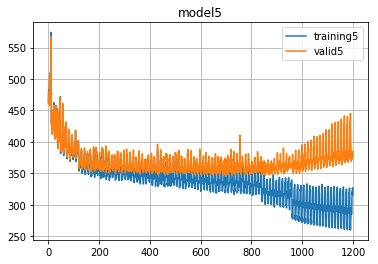

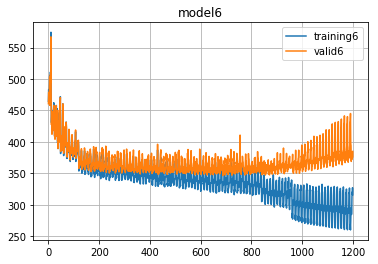

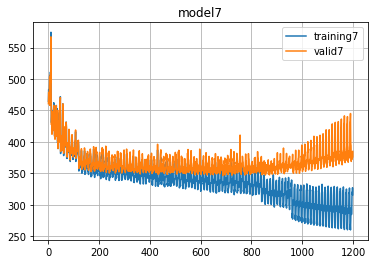

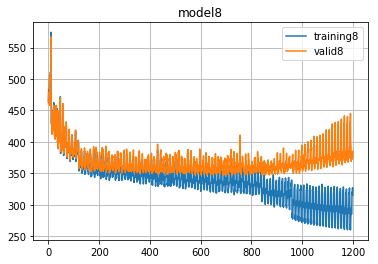

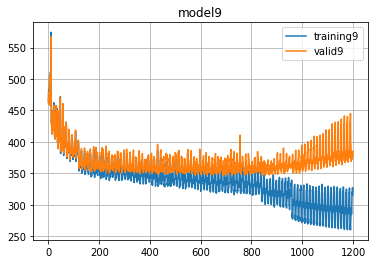

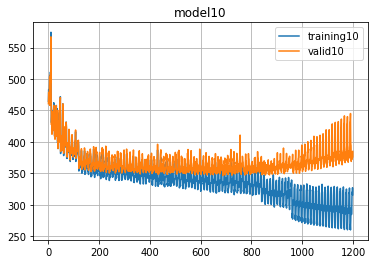

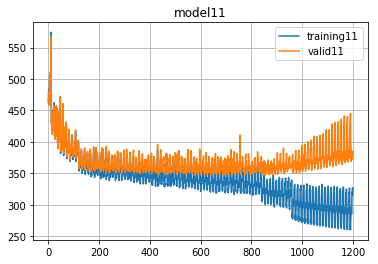

In [32]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

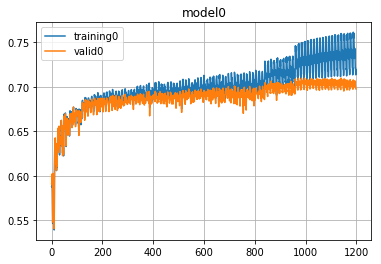

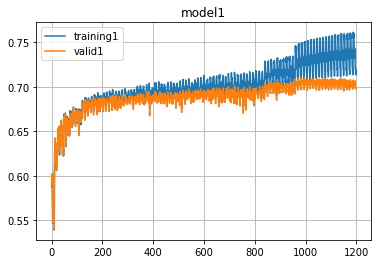

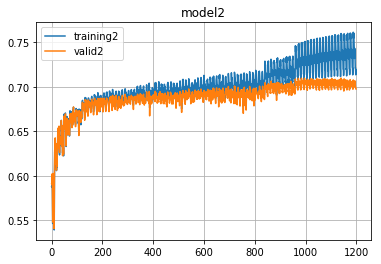

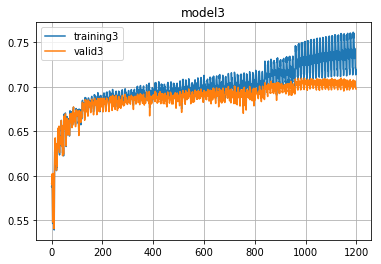

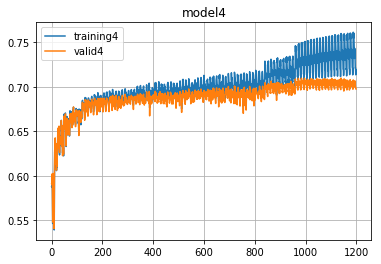

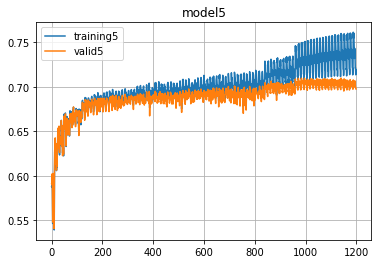

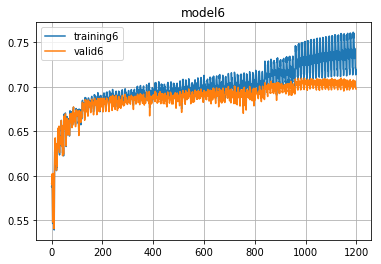

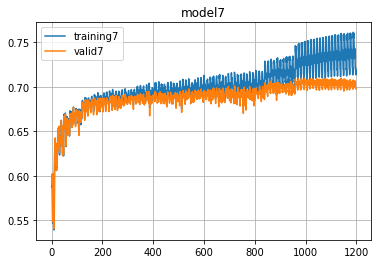

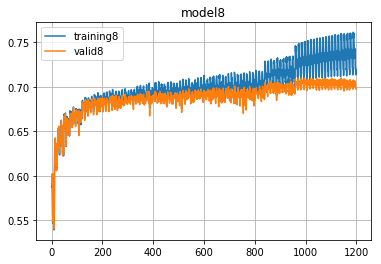

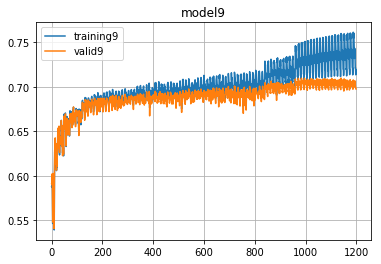

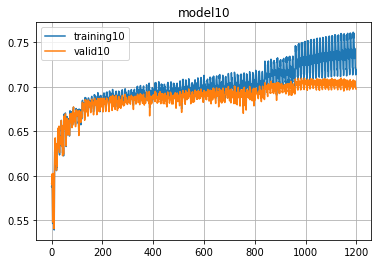

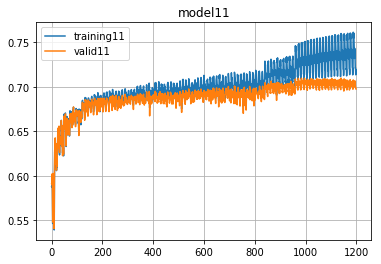

In [33]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

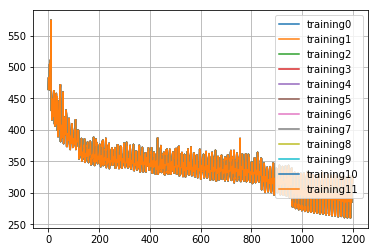

In [34]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

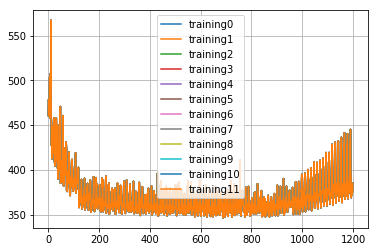

In [35]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

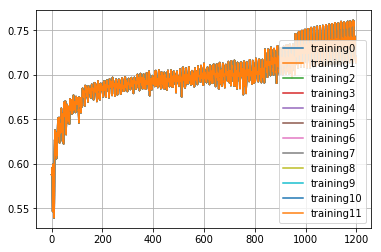

In [36]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

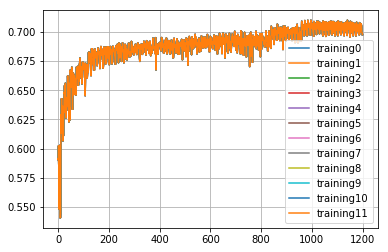

In [37]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

<br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_res_separated_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [38]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)

    total_lst = activity
    return total_lst, label

In [39]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [40]:
print(test_data.shape)

(40000, 304)


<br></br><br></br><br></br> 

# Predict

In [41]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

week: 11316, month: 5539, 2month: 12900, retained: 10245
week: 11353, month: 5740, 2month: 12768, retained: 10139
week: 11172, month: 5711, 2month: 13124, retained: 9993
week: 11339, month: 5842, 2month: 12254, retained: 10565
week: 11519, month: 4676, 2month: 13459, retained: 10346
week: 11351, month: 4715, 2month: 13415, retained: 10519
week: 11736, month: 4897, 2month: 13255, retained: 10112
week: 11537, month: 5037, 2month: 13089, retained: 10337
week: 11661, month: 3899, 2month: 13523, retained: 10917
week: 11562, month: 4064, 2month: 13872, retained: 10502
week: 11884, month: 3844, 2month: 13711, retained: 10561
week: 11371, month: 4090, 2month: 14180, retained: 10359


In [42]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [43]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()

,acc_id,0,1,2,3,4,5,6,7,8,9,10,11
0,0002a56a036206aea3a6c6ebc985df4a2d1987b562e7f0...,2,2,2,2,2,2,2,2,2,2,2,2
1,0003bfdebe2b5d46217e8fa5ab0f33cf186fb558435f20...,0,0,0,0,0,0,0,0,0,0,0,0
2,0008f5dce798aaac3f0b05f8a4269cf2052c9b8c5bd911...,2,2,2,2,2,2,2,2,2,2,2,2
3,000cacd86bddabebef813351455304df5493cd71a3d1d2...,2,2,2,2,2,2,2,2,2,2,2,2
4,000ef0765596ac6a6a0a62654895e4673825b6102c7f41...,2,2,2,3,2,2,2,2,2,2,2,2
